In [137]:
from __future__ import print_function
# from IPython.display import Math, HTML
import keras
import struct
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose
from keras.models import Model
from keras.optimizers import RMSprop, Adam, SGD

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3759101026736429458
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15075795929592423897
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Dataset Exploration

Shape of MNIST train images: (10000, 28, 28)
Shape of MNIST test images: (4000, 28, 28)


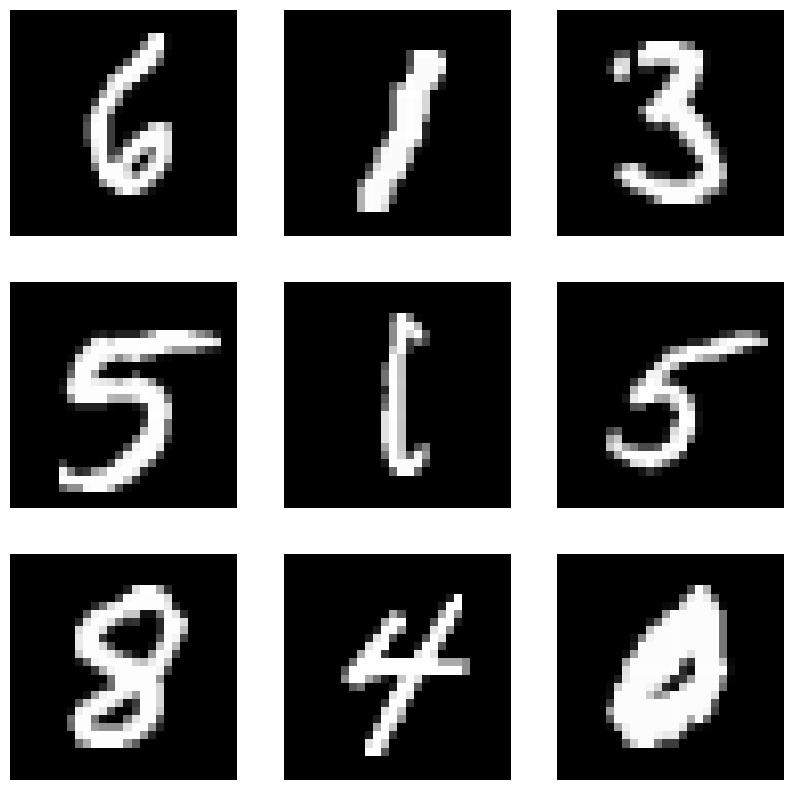

In [138]:
from keras.datasets import mnist

# load dataset
(train_data, y_train),(test_data, y_test) = mnist.load_data()

# keep 10k images for train data
train_data = train_data[:10000]

# keep 4k images for test data
test_data = test_data[:4000]

# Print the shape of the data
print(f'Shape of MNIST train images: {train_data.shape}')
print(f'Shape of MNIST test images: {test_data.shape}')

# Display 9 random images in training data
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(train_data[np.random.randint(0, 10000)], cmap='gray')
        ax[i, j].axis('off')
plt.show()


# Data Pre-processing

In [139]:
train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)
# check the shape of the data
print(f'Shape of MNIST images: {train_data.shape}')

# convert the data type to float32
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# check the type of the data
print(f'Type of MNIST train images: {train_data.dtype}')
print(f'Type of MNIST test images: {test_data.dtype}')


# normalize the data
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

# check the range of the data
print(f'Range of MNIST test images: {train_data.min()} to {train_data.max()}')
print(f'Range of MNIST train images: {test_data.min()} to {test_data.max()}')

# parition the data into training and validation sets
from sklearn.model_selection import train_test_split
train_X, valid_X, train_ground, valid_ground = train_test_split(train_data,
                                                                train_data,
                                                                test_size=0.2)

# print the shape of training data and validation data
print(f'Shape of training data: {train_X.shape}')
print(f'Shape of validation data: {valid_X.shape}')

print(f'Shape of training labels: {train_ground.shape}')
print(f'Shape of validation labels: {valid_ground.shape}')

Shape of MNIST images: (10000, 28, 28, 1)
Type of MNIST train images: float32
Type of MNIST test images: float32
Range of MNIST test images: 0.0 to 1.0
Range of MNIST train images: 0.0 to 1.0
Shape of training data: (8000, 28, 28, 1)
Shape of validation data: (2000, 28, 28, 1)
Shape of training labels: (8000, 28, 28, 1)
Shape of validation labels: (2000, 28, 28, 1)


# The Convolutional Autoencoder

In [140]:
batch_size = 128
epochs = 60
inChannel = 1
x, y = 28, 28
input_img = Input(shape=(x, y, inChannel))

In [141]:
# Latent dimension (change the size as needed)
latent_dim = 28

def encoder(input_img):
    # Encoder layers
    conv1 = Conv2D(32, (7, 7), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (7, 7), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (7, 7), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    # create a flattened layer
    flat = Flatten()(conv3)
    # create a bottleneck layer
    bottleneck = Dense(latent_dim, activation='relu')(flat)

    return bottleneck

def decoder(bottleneck):
    # Decoder layers
    reshape_bottleneck = Dense(7 * 7 * 128, activation='relu')(bottleneck)
    reshape_bottleneck = Reshape((7, 7, 128))(reshape_bottleneck)
    conv4 = Conv2D(128, (7, 7), activation='relu', padding='same')(reshape_bottleneck)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(64, (7, 7), activation='relu', padding='same')(up1)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2, 2))(conv5)
    conv6 = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(up2)

    return conv6

# Input layer
input_img = Input(shape=(28, 28, 1))

# autoencoder model
autoencoder_model = Model(input_img, decoder(encoder(input_img)))

# Compile the autoencoder model
autoencoder_model.compile(loss='mean_squared_error', optimizer=RMSprop(0.01))

# Print model summaries
autoencoder_model.summary()

Model: "model_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_72 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_138 (Conv2D)         (None, 28, 28, 32)        1600      
                                                                 
 batch_normalization_115 (B  (None, 28, 28, 32)        128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_139 (Conv2D)         (None, 14, 14, 64)        100416    
                                                                 
 batch_normalization_116 (B  (None, 14, 14, 64)        256

# Train the model

In [142]:
autoencoder_train = autoencoder_model.fit(train_X, train_ground, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(valid_X, valid_ground))

# Create the encoder model
encoder_model = Model(input_img, autoencoder_model.layers[10].output)

# Create the decoder model using layers from the pre-trained autoencoder model
decoder_input = Input(shape=(latent_dim,))
decoder_layers = autoencoder_model.layers[-9:]
decoded_layers = decoder_input

for layer in decoder_layers:
    decoded_layers = layer(decoded_layers)

# Create the decoder model
decoder_model = Model(decoder_input, decoded_layers)

# Compile the autoencoder model
encoder_model.compile(loss='mean_squared_error', optimizer=RMSprop(0.01))
decoder_model.compile(loss='mean_squared_error', optimizer=RMSprop(0.01))

# Print model summaries
encoder_model.summary()
decoder_model.summary()


Epoch 1/30
63/63 [==============================] - 5s 39ms/step - loss: 0.1232 - val_loss: 0.1093
Epoch 2/30
63/63 [==============================] - 2s 33ms/step - loss: 0.1107 - val_loss: 0.1885
Epoch 3/30
63/63 [==============================] - 2s 33ms/step - loss: 0.1112 - val_loss: 0.1039
Epoch 4/30
63/63 [==============================] - 2s 33ms/step - loss: 0.1024 - val_loss: 0.1050
Epoch 5/30
63/63 [==============================] - 2s 31ms/step - loss: 0.0989 - val_loss: 0.1040
Epoch 6/30
63/63 [==============================] - 2s 33ms/step - loss: 0.0958 - val_loss: 0.2511
Epoch 7/30
63/63 [==============================] - 2s 35ms/step - loss: 0.0821 - val_loss: 0.0659
Epoch 8/30
63/63 [==============================] - 2s 37ms/step - loss: 0.0591 - val_loss: 0.0782
Epoch 9/30
63/63 [==============================] - 2s 34ms/step - loss: 0.0504 - val_loss: 0.0746
Epoch 10/30
63/63 [==============================] - 2s 33ms/step - loss: 0.0419 - val_loss: 0.0494
Epoch 11/

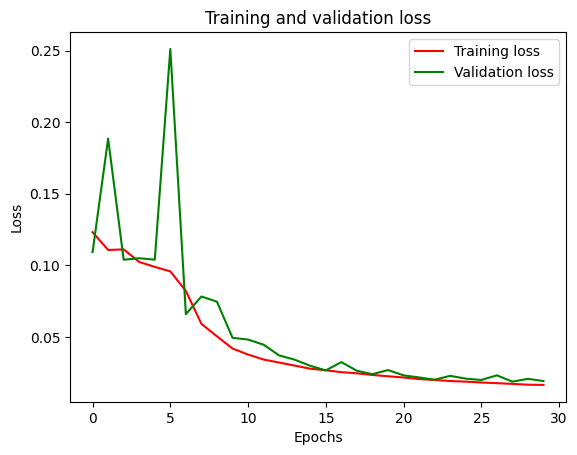

In [143]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, '-r', label='Training loss')
plt.plot(epochs, val_loss, '-g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test the Model

125/125 [==============================] - 1s 3ms/step
=========================================================== Image 1 ===========================================================


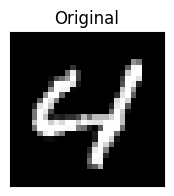

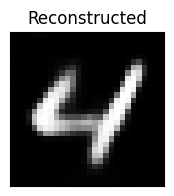

1/1 [==============================] - 0s 149ms/step
Encoded Representation Shape: (1, 28)
1/1 [==============================] - 0s 184ms/step


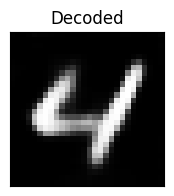

=========================================================== Image 2 ===========================================================


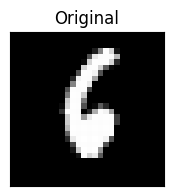

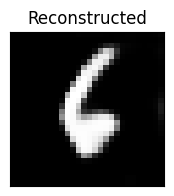

1/1 [==============================] - 0s 26ms/step
Encoded Representation Shape: (1, 28)
1/1 [==============================] - 0s 17ms/step


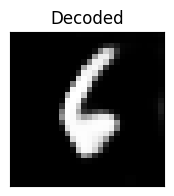

=========================================================== Image 3 ===========================================================


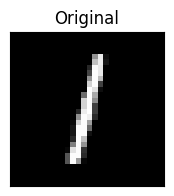

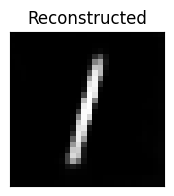

1/1 [==============================] - 0s 27ms/step
Encoded Representation Shape: (1, 28)
1/1 [==============================] - 0s 17ms/step


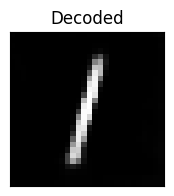

=========================================================== Image 4 ===========================================================


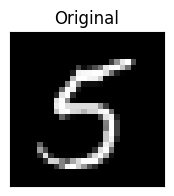

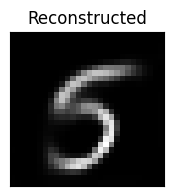

1/1 [==============================] - 0s 23ms/step
Encoded Representation Shape: (1, 28)
1/1 [==============================] - 0s 17ms/step


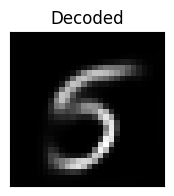

=========================================================== Image 5 ===========================================================


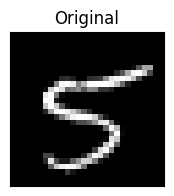

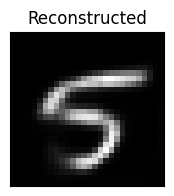

1/1 [==============================] - 0s 38ms/step
Encoded Representation Shape: (1, 28)
1/1 [==============================] - 0s 25ms/step


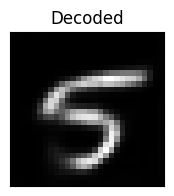

=========================================================== Image 6 ===========================================================


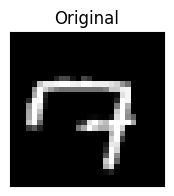

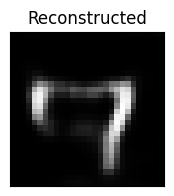

1/1 [==============================] - 0s 36ms/step
Encoded Representation Shape: (1, 28)
1/1 [==============================] - 0s 23ms/step


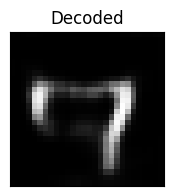

=========================================================== Image 7 ===========================================================


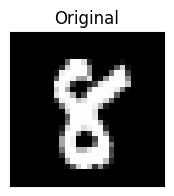

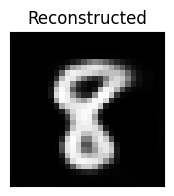

1/1 [==============================] - 0s 42ms/step
Encoded Representation Shape: (1, 28)
1/1 [==============================] - 0s 26ms/step


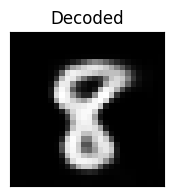

=========================================================== Image 8 ===========================================================


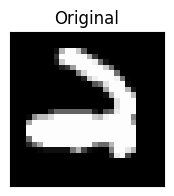

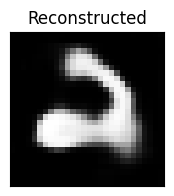

1/1 [==============================] - 0s 29ms/step
Encoded Representation Shape: (1, 28)
1/1 [==============================] - 0s 26ms/step


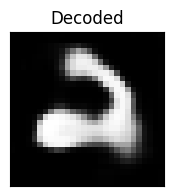

=========================================================== Image 9 ===========================================================


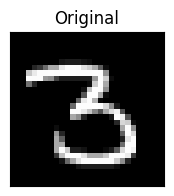

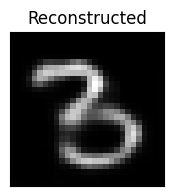

1/1 [==============================] - 0s 27ms/step
Encoded Representation Shape: (1, 28)
1/1 [==============================] - 0s 31ms/step


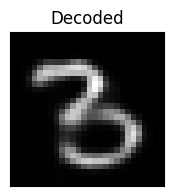

=========================================================== Image 10 ===========================================================


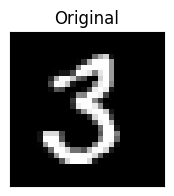

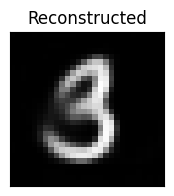

1/1 [==============================] - 0s 27ms/step
Encoded Representation Shape: (1, 28)
1/1 [==============================] - 0s 37ms/step


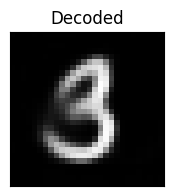

In [144]:
# Save the models
autoencoder_model.save('autoencoder.h5')
encoder_model.save('encoder.h5')
decoder_model.save('decoder.h5')  # Save the decoder model separately

# Predict the autoencoder output from test images
pred = autoencoder_model.predict(test_data)

# Predict the encoder output from test images
encoded_data = encoder_model.predict(test_data)

# Generate 10 random indices
random_indices = np.random.choice(test_data.shape[0], size=10, replace=False)

for j in range(10):
    index = random_indices[j]
    print(
        f'=========================================================== Image {j+1} ===========================================================')

    # Display the original image in a separate plot
    fig_original, ax_original = plt.subplots(figsize=(2, 2))
    ax_original.imshow(test_data[index, :, :, 0], cmap='gray')
    ax_original.set_title('Original')
    ax_original.get_xaxis().set_visible(False)
    ax_original.get_yaxis().set_visible(False)
    plt.show()

    # Display the image after reconstruction
    fig_reconstructed, ax_reconstructed = plt.subplots(figsize=(2, 2))
    ax_reconstructed.imshow(pred[index, :, :, 0], cmap='gray')
    ax_reconstructed.set_title('Reconstructed')
    ax_reconstructed.get_xaxis().set_visible(False)
    ax_reconstructed.get_yaxis().set_visible(False)
    plt.show()

    # Obtain encoded representation using the encoder model
    encoded_representation = encoder_model.predict(test_data[index:index + 1])

    # Display the encoded representation
    print(f'Encoded Representation Shape: {encoded_representation.shape}')

    # Obtain decoded representation using the decoder model
    decoded_representation = decoder_model.predict(encoded_representation)

    # Display the decoded representation
    fig_decoded, ax_decoded = plt.subplots(figsize=(2, 2))
    ax_decoded.imshow(decoded_representation[0, :, :, 0], cmap='gray')
    ax_decoded.set_title('Decoded')
    ax_decoded.get_xaxis().set_visible(False)
    ax_decoded.get_yaxis().set_visible(False)
    plt.show()